In [1]:
from src.application.services.portfolio_constructor import Portfolio_Constructor
from src.domain.stats.betting_statistics import BetsToEquity, drawdown, total_return, annual_return, equity_to_variations_month_year
import datetime as dt
import pandas as pd

/usr/local/lib/python3.8/site-packages/arctic/store/_pandas_ndarray_store.py:8: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


BACKTESTING A BETTING STRATEGY

2) Backtesting

In [2]:
# SETTING

provider = 'betfair'
start_date = dt.datetime(2022,1,1) # Start date for backtesting
end_date = dt.datetime(2023, 1, 1)

strategy1 = {'id': 1, # unique id for strategy to run
             'strategy': 'Basic_Strategy', # strategy name, create in smartbots/betting/strategies
             'params': {'ticker': 'over/under 2.5 goals',
             'selection': 'over 2.5 goals',
             'action': 'back',
             'quantity': 2,
             'init_odd':1.5,
             'end_odd': 1.7,
             'init_time':10,
             'end_time': 30,
             'diff_odds': 0.03}}


conf_portfolio = {'Name': 'PortfolioBetting1',
                  'Data_Sources': 
                  [{'ticker': 'over/under 2.5 goals',
                   'event_type': 'odds',
                   'historical_source': 'mongoDB',
                   'historical_library': f'{provider}_files_historical'}],
                   'Strategies': 
                    [strategy1]}

In [6]:
%%time
portfolio = Portfolio_Constructor(conf_portfolio, run_real=False, asset_type='betting',
                                  send_orders_to_broker=False, start_date=start_date, end_date=end_date)
print('Generating Backtesting....you need to wait')
portfolio.run_simulation() # backtest 
bets = portfolio.bets
result = portfolio.bets_result

Generating Backtesting....you need to wait
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1316, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 4, in <module>
  File "/app/smartbots/engine/portfolio_constructor.py", line 110, in run_simulation
  File "/app/smartbots/engine/data_reader.py", line 117, in load_tickers_and_create_events_betting
    data = lib.read(unique).data
  File "/usr/local/lib/python3.8/site-packages/arctic/store/version_store.py", line 356, in read
    return self._do_read(symbol, _version, from_version,
  File "/usr/local/lib/python3.8/site-packages/arctic/store/version_store.py", line 441, in _do_read
    data = handler.read(self._arctic_lib, version, symbol, from_version=from_version, **kwargs)
  File "/usr/local/lib/python3.8/site-packages/arctic/store/_pickle_store.py", line 62, in read
    return pickle_compat_load(io.BytesIO(data))
  File "/usr/local/lib/python3.8/site-packages/pandas/compat/pickle_compat.py"

In [8]:
# BETTING STATS

bets_to_equity = BetsToEquity(bets, result, capital_init=2000, commission=0.02)
df_equity = pd.DataFrame({'equity': bets_to_equity.equity, 'datetime': bets_to_equity.datetime})
df_equity['datetime'] = df_equity['datetime'].dt.date
# convert to datetime
df_equity['datetime'] = pd.to_datetime(df_equity['datetime'])
# get daily equity
df_equity = df_equity.drop_duplicates(subset='datetime', keep='last')
# datetime to index
df_equity.index = df_equity['datetime']
# get draw down
draw = drawdown(df_equity.index, df_equity['equity'])

statistics = {}
statistics['max_draw'] = round(max(draw['draw_down']) * 100, 3)
statistics['max_draw_dur'] = max(draw['drawdowndur'])
statistics['annual_return'] = round(annual_return(df_equity['equity'], difference_prices=False), 3)
statistics['total_return'] = round(total_return(df_equity['equity']), 2)
statistics['calmar'] = round(statistics['annual_return'] / statistics['max_draw'], 3)
statistics['bets'] = bets_to_equity.success + bets_to_equity.failed
statistics['average_oods'] = bets_to_equity.sum_odds / statistics['bets']
statistics['probability_odds'] = 1 / statistics['average_oods'] * 100
statistics['reliability'] = round(bets_to_equity.success / statistics['bets'] * 100, 3)

print(statistics)


{'max_draw': 0.622, 'max_draw_dur': 1.0, 'annual_return': 23.951, 'total_return': 0.29, 'calmar': 38.506, 'bets': 145, 'average_oods': 1.5638620689655178, 'probability_odds': 63.94425824660431, 'reliability': 66.207}


In [5]:
# GET MONTH VARIATIONS
equity_to_variations_month_year(df_equity['equity'], _type='M')

datetime
2022-09-30    0.089686
Freq: -1M, Name: equity, dtype: float64

,equity,datetime
datetime,,
2022-09-07,2001.2152,2022-09-07
2022-09-08,1995.8300,2022-09-08
2022-09-09,1983.4100,2022-09-09
2022-09-10,1997.2900,2022-09-10
2022-09-11,2007.1100,2022-09-11


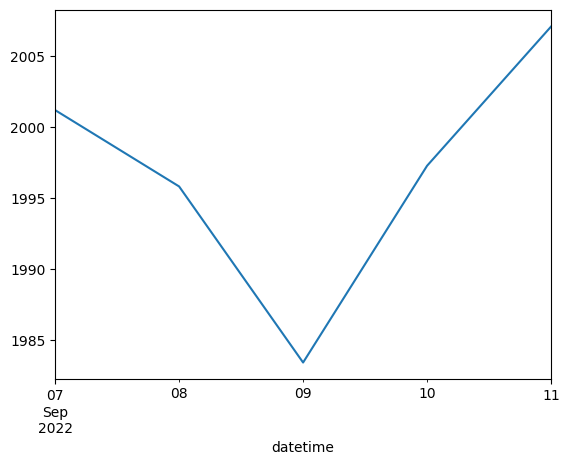

In [9]:
# VISUALIZE EQUITY
df_equity['equity'].plot()
df_equity